In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/release_in_the_wild.zip"

Streaming output truncated to the last 5000 lines.
  inflating: release_in_the_wild/550.wav  
  inflating: release_in_the_wild/5500.wav  
  inflating: release_in_the_wild/5501.wav  
  inflating: release_in_the_wild/5502.wav  
  inflating: release_in_the_wild/5503.wav  
  inflating: release_in_the_wild/5504.wav  
  inflating: release_in_the_wild/5505.wav  
  inflating: release_in_the_wild/5506.wav  
  inflating: release_in_the_wild/5507.wav  
  inflating: release_in_the_wild/5508.wav  
  inflating: release_in_the_wild/5509.wav  
  inflating: release_in_the_wild/551.wav  
  inflating: release_in_the_wild/5510.wav  
  inflating: release_in_the_wild/5511.wav  
  inflating: release_in_the_wild/5512.wav  
  inflating: release_in_the_wild/5513.wav  
  inflating: release_in_the_wild/5514.wav  
  inflating: release_in_the_wild/5515.wav  
  inflating: release_in_the_wild/5516.wav  
  inflating: release_in_the_wild/5517.wav  
  inflating: release_in_the_wild/5518.wav  
  inflating: release_in_the

# Imports and hyperparameter configuration

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tqdm import tqdm

from google.colab import files
import shutil

In [ ]:
# Paths to audio files and metadata
audio_folder = "/content/release_in_the_wild"
meta_path = "/content/final_updated_meta.csv"

# Load metadata
meta_full = pd.read_csv(meta_path)
print(f"Loaded metadata with {len(meta_full)} entries.")

# Splitting the metadata
meta = meta_full.iloc[:19963]  # From index 0 to 19962
split2 = meta_full.iloc[19963:]  # From index 19963 to 24247

# Display the sizes of the splits
print(f"Split1 size: {len(meta)} entries.")
print(f"Split2 size: {len(split2)} entries.")



Loaded metadata with 24248 entries.
Split1 size: 19963 entries.
Split2 size: 4285 entries.


In [ ]:
# Hyperparameters configuration
n_mfcc = 13
n_mels = 128
max_frames = 300
sr = 16000
batch_size = 32
epochs = 20
random_seed = 42

# Feature extraction methods

In [ ]:
def extract_mfcc_feature(audio_file, sr=16000, n_mfcc=13):
    """ This function extracts 2D MFCC features and returns a 2D array for each audio file."""
    try:
        y, sr = librosa.load(audio_file, sr=sr)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccs = librosa.util.normalize(mfccs)
        mfccs = librosa.util.fix_length(mfccs, size=max_frames, axis=1)  # Pad/Truncate
        return mfccs
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

In [ ]:
def extract_mel_spectrogram(audio_file, sr=16000, n_mels=128, max_frames=300):
    """Extracts Mel-spectrogram features from an audio file."""
    try:
        y, sr = librosa.load(audio_file, sr=sr)
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        mel_spectrogram_db = librosa.util.normalize(mel_spectrogram_db)
        mel_spectrogram_db = librosa.util.fix_length(mel_spectrogram_db, size=max_frames, axis=1)
        return mel_spectrogram_db
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

# Plotting some mfcc and mel_spectogram figures

In [ ]:
# Select Sample Audio Files
unique_speakers = meta['speaker'].unique()
num_speakers_to_visualize = 6
np.random.seed(random_seed)
selected_speakers = np.random.choice(unique_speakers, size=num_speakers_to_visualize, replace=False)
sample_files = []
for speaker in selected_speakers:
    speaker_files = meta[meta['speaker'] == speaker]['file'].tolist()
    selected_file = np.random.choice(speaker_files)
    sample_files.append((speaker, selected_file))

print("Selected Samples for Visualization:")
for speaker, file in sample_files:
    print(f"Speaker: {speaker}, File: {file}")

Selected Samples for Visualization:
Speaker: Jimmy Carter, File: 1811.wav
Speaker: Frank Sinatra, File: 3332.wav
Speaker: George W. Bush, File: 6662.wav
Speaker: Ronald Reagan, File: 3297.wav
Speaker: Orson Welles, File: 12307.wav
Speaker: Barack Obama, File: 18125.wav


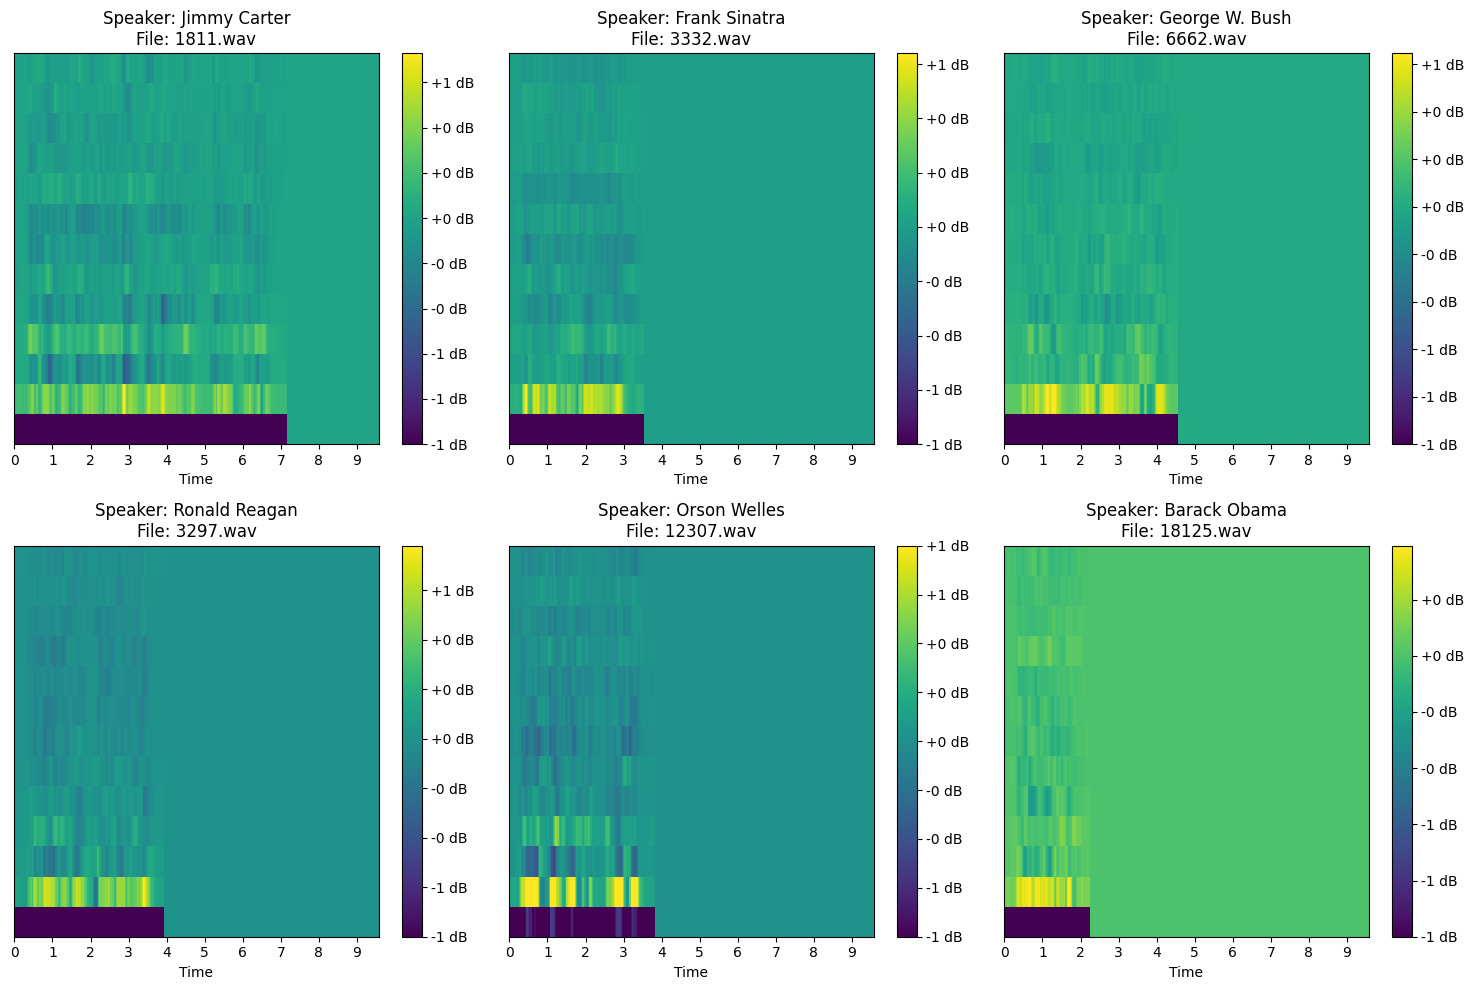

In [ ]:
def plot_mfcc_grid(sample_files, sr=16000, n_mfcc=13, max_frames=300, grid_size=(2, 3)):
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten in case of multiple rows/cols

    for idx, (speaker, file) in enumerate(sample_files):
        if idx >= rows * cols:
            break  # Avoid indexing errors if more samples than grid spaces
        file_path = os.path.join(audio_folder, file)
        try:
            y, sr = librosa.load(file_path, sr=sr)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
            mfccs = librosa.util.normalize(mfccs)
            mfccs = librosa.util.fix_length(mfccs, size=max_frames, axis=1)

            img = librosa.display.specshow(mfccs, x_axis='time', sr=sr, hop_length=512, ax=axes[idx], cmap='viridis')
            axes[idx].set_title(f"Speaker: {speaker}\nFile: {file}")
            fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')
        except Exception as e:
            axes[idx].set_title(f"Error: {file}")
            axes[idx].axis('off')
            print(f"Error processing {file_path}: {e}")

    # Hide any unused subplots
    for i in range(len(sample_files), rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_mfcc_grid(sample_files, sr=sr, n_mfcc=n_mfcc, max_frames=max_frames, grid_size=(2, 3))

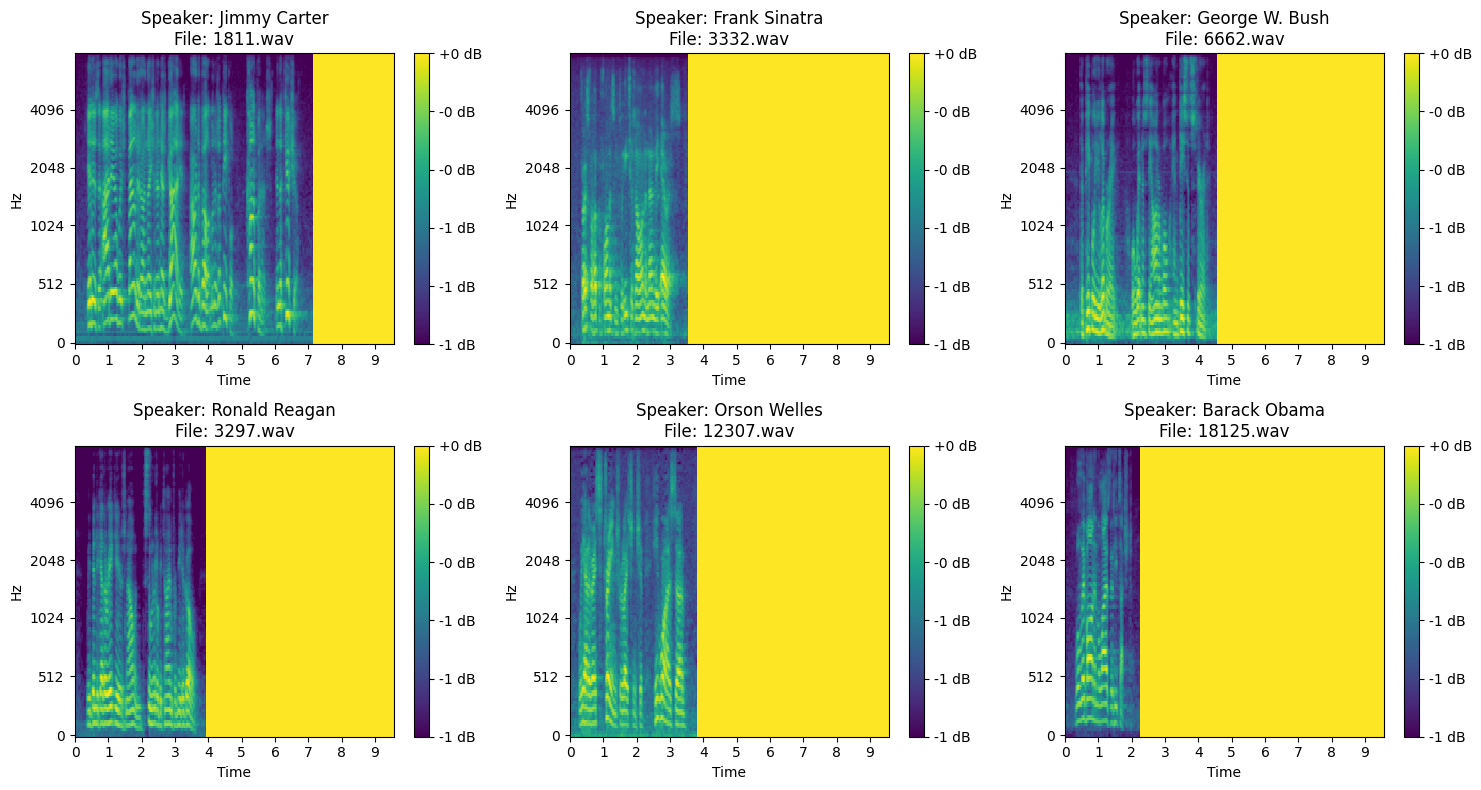

In [ ]:
def plot_mel_spectrogram_grid(sample_files, audio_folder, sr=16000, n_mels=128, max_frames=300, grid_size=(2, 3)):
    """Plots Mel-spectrograms of multiple audio samples in a grid layout."""
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  # Flatten in case of multiple rows/cols

    for idx, (speaker, file_name) in enumerate(sample_files):
        if idx >= rows * cols:
            break  # Avoid indexing errors if more samples than grid spaces
        file_path = os.path.join(audio_folder, file_name)
        try:
            y, sr = librosa.load(file_path, sr=sr)
            mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
            mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
            mel_spectrogram_db = librosa.util.normalize(mel_spectrogram_db)
            mel_spectrogram_db = librosa.util.fix_length(mel_spectrogram_db, size=max_frames, axis=1)
            img = librosa.display.specshow(mel_spectrogram_db,
                                           x_axis='time',
                                           y_axis='mel',
                                           sr=sr,
                                           hop_length=512,
                                           cmap='viridis',
                                           ax=axes[idx])
            axes[idx].set_title(f"Speaker: {speaker}\nFile: {file_name}")
            fig.colorbar(img, ax=axes[idx], format='%+2.0f dB')
        except Exception as e:
            axes[idx].set_title(f"Error: {file_name}")
            axes[idx].axis('off')
            print(f"Error processing {file_path}: {e}")

    # Hide any unused subplots
    for i in range(len(sample_files), rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


plot_mel_spectrogram_grid(sample_files, audio_folder, sr=16000, n_mels=128, max_frames=300, grid_size=(2, 3))

# Audio input normalization

The audio normalization consists of following steps:  
1. Removing outliers
2. Remove imbalanced classes

## Remove outliers from data folder and metadata file

In [ ]:
def display_summary_statistics(durations):
    """
    Displays summary statistics for audio durations.

    Parameters:
    - durations: List of durations (in seconds).
    """
    import numpy as np

    durations_np = np.array(durations)
    median_duration = np.median(durations_np)
    std_duration = np.std(durations_np)
    min_duration = np.min(durations_np)
    max_duration = np.max(durations_np)

    print("=== Audio Duration Summary ===")
    print(f"Number of Audio Files: {len(durations)}")
    print(f"Average Duration: {average_duration:.2f} seconds")
    print(f"Median Duration: {median_duration:.2f} seconds")
    print(f"Standard Deviation: {std_duration:.2f} seconds")
    print(f"Minimum Duration: {min_duration:.2f} seconds")
    print(f"Maximum Duration: {max_duration:.2f} seconds")
    print("==============================")


def plot_duration_histogram(durations, average_duration, bins=30):
    """
    Plots a histogram of audio durations with the average duration annotated.

    Parameters:
    - durations: List of durations (in seconds).
    - average_duration: Average duration in seconds.
    - bins: Number of histogram bins.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(durations, bins=bins, kde=True, color='skyblue', edgecolor='black')

    # Plot the average duration as a vertical line
    plt.axvline(average_duration, color='red', linestyle='--', linewidth=2, label=f'Average Duration: {average_duration:.2f}s')

    # Enhance the plot
    plt.title('Distribution of Audio Durations', fontsize=16)
    plt.xlabel('Duration (seconds)', fontsize=14)
    plt.ylabel('Number of Audio Files', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def identify_outliers(durations, threshold=1.5):
    """
    Identifies outliers in audio durations using the IQR method.

    Parameters:
    - durations: List of durations (in seconds).
    - threshold: Multiplicative factor for IQR to determine outliers.

    Returns:
    - outliers: List of durations identified as outliers.
    """
    Q1 = np.percentile(durations, 25)
    Q3 = np.percentile(durations, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    outliers = [d for d in durations if d < lower_bound or d > upper_bound]
    return outliers


def remove_outliers(meta, column='duration', threshold=1.5):
    """
    Removes rows from the DataFrame where the values in the specified column are outliers.

    Parameters:
    - meta (pd.DataFrame): DataFrame containing the column to check for outliers.
    - column (str): Column name to check for outliers.
    - threshold (float): Threshold for IQR to determine outliers.

    Returns:
    - meta (pd.DataFrame): Updated DataFrame with outliers removed.
    """
    durations = meta[column].tolist()
    outliers = identify_outliers(durations, threshold=threshold)
    initial_count = len(meta)

    # Remove rows with outlier durations
    meta = meta[~meta[column].isin(outliers)].reset_index(drop=True)
    final_count = len(meta)
    removed = initial_count - final_count
    print(f"Removed {removed} outlier entries.")

    return meta

In [ ]:
def calculate_durations(meta, audio_folder, sr=16000):
    """
    Calculates the duration of each audio file and adds it as a new column in the metadata DataFrame.

    Parameters:
    - meta (pd.DataFrame): DataFrame containing at least a 'file' column.
    - audio_folder (str): Path to the folder containing audio files.
    - sr (int): Sampling rate for loading audio files.

    Returns:
    - meta (pd.DataFrame): Updated DataFrame with a new 'duration' column.
    """
    durations = []
    for idx, row in tqdm(meta.iterrows(), total=len(meta), desc="Calculating Durations"):
        file_name = row['file']
        file_path = os.path.join(audio_folder, file_name)
        try:
            duration = librosa.get_duration(filename=file_path, sr=sr)
            durations.append(duration)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            durations.append(None)  # Append None for failed files

    # Add durations to DataFrame
    meta['duration'] = durations

    # Optionally, remove entries with None durations
    initial_count = len(meta)
    meta = meta.dropna(subset=['duration']).reset_index(drop=True)
    final_count = len(meta)
    removed = initial_count - final_count
    if removed > 0:
        print(f"Removed {removed} entries due to failed duration calculations.")

    return meta

# Calculate durations
meta = calculate_durations(meta, audio_folder, sr=16000)
print(f"Metadata now contains 'duration' column.")

Calculating Durations:   0%|          | 0/19963 [00:00<?, ?it/s]<ipython-input-9-bfa2b559a955>:18: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=file_path, sr=sr)
Calculating Durations: 100%|██████████| 19963/19963 [11:26<00:00, 29.08it/s]

Metadata now contains 'duration' column.



<ipython-input-9-bfa2b559a955>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta['duration'] = durations


In [ ]:
# Compute duration sumamry
average_duration = np.mean(meta['duration'].to_list())
display_summary_statistics(meta['duration'].to_list())

=== Audio Duration Summary ===
Number of Audio Files: 19963
Average Duration: 3.74 seconds
Median Duration: 2.99 seconds
Standard Deviation: 2.78 seconds
Minimum Duration: 0.44 seconds
Maximum Duration: 24.95 seconds


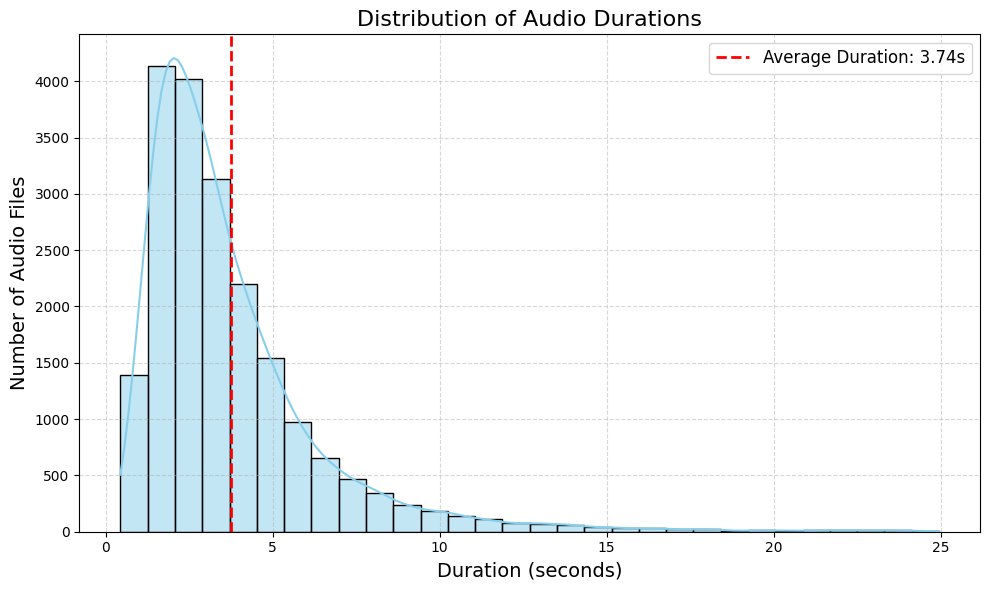

In [ ]:
plot_duration_histogram(meta['duration'].to_list(), average_duration, bins=30)

Removed 1155 outlier entries.
Outliers have been removed from the DataFrame.


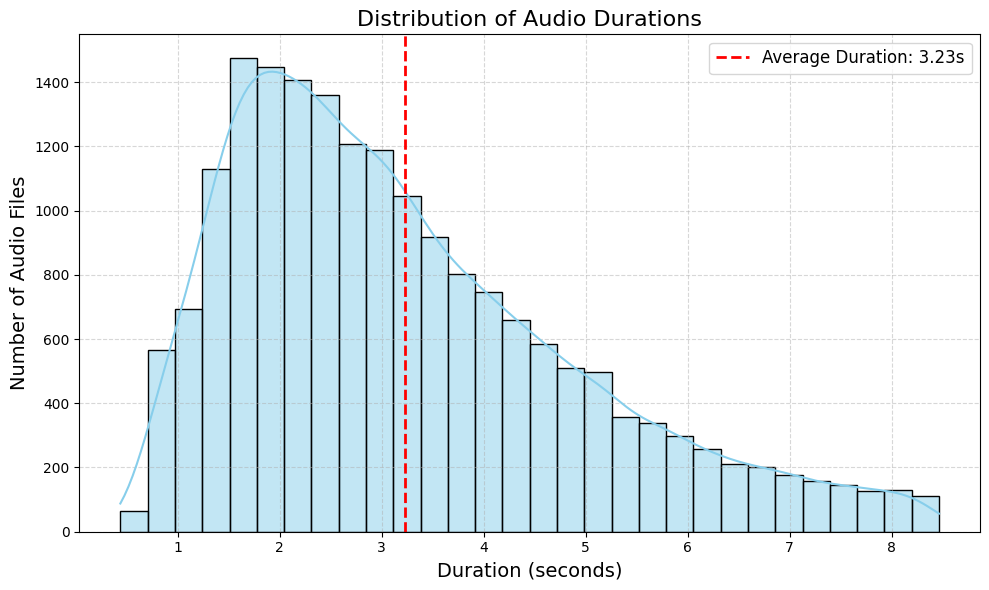

In [ ]:
# Step 2: Remove outliers
meta = remove_outliers(meta, column='duration', threshold=1.5)
print("Outliers have been removed from the DataFrame.")

# Plot clean durations
clean_durations = meta['duration'].tolist()
clean_average_duration = np.mean(clean_durations)
plot_duration_histogram(clean_durations, clean_average_duration, bins=30)

## Remove imbalanced classes

In [ ]:
def aggregate_audio_data_by_speaker(meta, duration_column='duration'):
    """
    Aggregates audio data to compute:
    - Total number of audio files per speaker.
    - Total duration of audio files per speaker.
    - Average duration per audio file for each speaker.

    Parameters:
    - meta (pd.DataFrame): DataFrame containing the data.
    - duration_column (str): Column name representing the audio duration.

    Returns:
    - aggregated_df (pd.DataFrame): Aggregated data with counts, total durations, and average durations per speaker.
    """
    aggregated_df = (
        meta.groupby('speaker')
        .agg(
            total_files=('file', 'count'),
            total_duration=(duration_column, 'sum'),
        )
        .reset_index()
    )

    # Add average duration per file
    aggregated_df['average_duration'] = (
        aggregated_df['total_duration'] / aggregated_df['total_files']
    )

    # Sort by total duration in descending order
    aggregated_df = aggregated_df.sort_values(by='total_duration', ascending=False).reset_index(drop=True)

    return aggregated_df


aggregate_audio_data_by_speaker(meta, duration_column='duration')

,speaker,total_files,total_duration,average_duration
0,Barack Obama,3098,11035.678000,3.562194
1,Donald Trump,3147,10230.536313,3.250885
2,Bernie Sanders,1513,5115.920687,3.381309
3,Alec Guinness,1818,4748.248312,2.611798
4,Ayn Rand,1356,4735.859875,3.492522
5,Bill Clinton,1117,3064.430750,2.743447
6,Christopher Hitchens,753,2610.130250,3.466308
7,Ronald Reagan,607,1902.231313,3.133824
8,Winston Churchill,623,1689.100062,2.711236
9,Martin Luther King,490,1364.259375,2.784203


### Randomly dropping tracks from extreme majority classes

In [ ]:
drop_counts = {
    'Barack Obama': 2000,
    'Donald Trump': 2000,
    'Bernie Sanders': 500,
    'Alec Guinness': 800,
    'Ayn Rand': 300
}

# Loop through each speaker and drop the specified number of records
for speaker, drop_count in drop_counts.items():
    speaker_data = meta[meta['speaker'] == speaker]

    # Randomly sample the records to drop
    drop_indices = np.random.choice(speaker_data.index, size=drop_count, replace=False)

    # Drop the selected records from the DataFrame
    meta = meta.drop(drop_indices)

# Reset the index after dropping
meta.reset_index(drop=True, inplace=True)

print(f"After dropping, the dataset contains {len(meta)} records.")

After dropping, the dataset contains 13208 records.


### Fully dropping extreme minority classes

In [ ]:
# Count the number of recordings per speaker
speaker_counts = meta['speaker'].value_counts()

# Get a list of speakers with fewer than 10 recordings
speakers_to_drop = speaker_counts[speaker_counts < 10].index

# Drop those speakers from the DataFrame
meta = meta[~meta['speaker'].isin(speakers_to_drop)]

# Reset index after dropping
meta.reset_index(drop=True, inplace=True)

print(f"After dropping, the dataset contains {len(meta)} records.")

After dropping, the dataset contains 13180 records.


In [ ]:
aggregate_audio_data_by_speaker(meta, duration_column='duration')

,speaker,total_files,total_duration,average_duration
0,Barack Obama,1177,3911.034187,3.322884
1,Donald Trump,1547,3731.497812,2.412086
2,Ayn Rand,1091,3698.069312,3.389614
3,Bernie Sanders,1035,3485.466625,3.367601
4,Bill Clinton,1226,3064.430750,2.499536
5,Alec Guinness,1050,2717.545813,2.588139
6,Christopher Hitchens,877,2610.130250,2.976203
7,Ronald Reagan,682,1902.231313,2.789195
8,Winston Churchill,623,1689.100062,2.711236
9,Martin Luther King,561,1364.259375,2.431835


In [ ]:

meta = pd.concat([meta, split2], ignore_index=True)

print(f"Loaded metadata with {len(meta)} entries.")
meta.to_csv("/content/processed_meta.csv", index=False)

Loaded metadata with 17465 entries.


# Dataset sampling for PoC development

In [ ]:
# Randomly sample 1/5 of the dataset to speed up the development process
sample_fraction = 1/5

meta_sampled = meta.sample(frac=sample_fraction, random_state=random_seed)
print(f"Sampled {len(meta_sampled)} entries for the development.")

# Comment out the line below to avoid training only on the subset of dataset
# meta = meta_sampled

Sampled 3993 entries for the development.


# MFCCs feature model training

In [ ]:
# Perform feature extraction
features, labels = [], []
for _, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing files"):
    file_path = os.path.join(audio_folder, row['file'])
    speaker = row['speaker']

    # Extract mfcc features
    feature = extract_mfcc_feature(file_path)

    # Extract mel_spectogram features
    #feature = extract_mel_spectrogram(file_path)

    if feature is not None:
        features.append(feature)
        labels.append(speaker)

Processing files: 100%|██████████| 17465/17465 [06:08<00:00, 47.45it/s]


In [ ]:
# Convert Data to 4D Tensor: CNNs expect input with dimensions (samples, height, width, channels)
X = np.array(features)  # Shape: (samples, n_mfcc, max_frames) or (samples, n_mels, max_frames)
X = X[..., np.newaxis]  # Add channel dimension: (samples, n_mfcc / n_mels, max_frames, 1)
y = np.array(labels)

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)

# For MFCCs
# The CNN model takes the 2D MFCC matrix as input
input_shape = (n_mfcc, max_frames, 1)
print(f"Feature shape: {X.shape}")  # Expected: (samples, n_mfcc, max_frames, 1)

# For mel spectograms
# The CNN model takes the 2D Mel-spectrogram matrix as input
# input_shape = (n_mels, max_frames, 1)
# print(f"Feature shape: {X.shape}") # Expected: (samples, n_mels, max_frames, 1)

Feature shape: (17465, 13, 300, 1)


In [ ]:
model = Sequential([
    tf.keras.Input(shape=(n_mfcc, max_frames, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 13, 300, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 6, 150, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 6, 150, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 150, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 3, 75, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 3, 75, 64)           │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 3, 75, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 37, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1, 37, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4736)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         606,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 52)                  │           6,708 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 706,612 (2.70 MB)

 Trainable params: 706,164 (2.69 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Define class weights based on training labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Create a dictionary of class weights
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

In [ ]:
# HPs
epochs = 200

# Define custom lr scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Train the model
model.fit(X_train, y_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_split=0.3,
          class_weight=class_weights_dict,
          callbacks=[lr_scheduler])

Epoch 1/200
268/268 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.0364 - loss: 4.1457 - val_accuracy: 0.0480 - val_loss: 4.0756 - learning_rate: 0.0010
Epoch 2/200
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0265 - loss: 3.9502 - val_accuracy: 0.0338 - val_loss: 3.8844 - learning_rate: 0.0010
Epoch 3/200
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0209 - loss: 3.8836 - val_accuracy: 0.0068 - val_loss: 3.8550 - learning_rate: 0.0010
Epoch 4/200
268/268 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.0063 - loss: 3.7973 - val_accuracy: 0.0063 - val_loss: 3.8466 - learning_rate: 0.0010
Epoch 5/200
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0086 - loss: 3.7789 - val_accuracy: 0.0060 - val_loss: 3.8158 - learning_rate: 0.0010
Epoch 6/200
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0069 - loss: 3.8383 - val_accuracy: 0.0125 - val_loss: 3.8934 - learning_rate: 0.0010
Epoch 7/200
268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.0063 - loss

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Detailed Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9404 - loss: 0.2259
Test Accuracy: 0.94
124/124 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
Classification Report:
                          precision    recall  f1-score   support

                    2Pac       1.00      1.00      1.00        15
             Adam Driver       1.00      1.00      1.00        19
              Alan Watts       0.70      0.88      0.78        24
           Alec Guinness       0.88      0.95      0.91       305
Alexandria Ocasio-Cortez       0.96      0.99      0.97        76
   Arnold Schwarzenegger       0.93      0.99      0.96        68
                Ayn Rand       0.98      0.96      0.97       317
            Barack Obama       0.91      0.94      0.92       329
          Bernie Sanders       0.96      0.95      0.95       304
               Bill Burr       0.97      0.91      0.94        33
            Bill Clinton       0.96      0.98      0.97       335
                Bob Ross       1.00      0.80  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Create a DataFrame for better manipulation
cm_df = pd.DataFrame(cm, index=encoder.classes_, columns=encoder.classes_)

# Set the diagonal to zero to exclude correct predictions
np.fill_diagonal(cm, 0)

# Stack the confusion matrix to have a long-form DataFrame
cm_stacked = cm_df.stack().reset_index()
cm_stacked.columns = ['Actual', 'Predicted', 'Count']

# Remove zero entries
cm_stacked = cm_stacked[cm_stacked['Count'] > 0]

# Sort by count descending
cm_sorted = cm_stacked.sort_values(by='Count', ascending=False)

# Display top N confused class pairs
top_n = 20
top_confusions = cm_sorted.head(top_n)

print(f"Top {top_n} Confused Class Pairs:")
print(top_confusions)

Top 20 Confused Class Pairs:
                    Actual              Predicted  Count
727           Donald Trump           Barack Obama     10
730           Donald Trump           Bill Clinton      9
331               Ayn Rand          Ronald Reagan      7
391         Bernie Sanders           Barack Obama      7
338           Barack Obama             Alan Watts      6
675   Christopher Hitchens          Alec Guinness      6
723           Donald Trump          Alec Guinness      5
1251           John Cleese          Alec Guinness      5
346           Barack Obama           Bill Clinton      4
351           Barack Obama           Donald Trump      4
291               Ayn Rand          Alec Guinness      4
1783         Nick Offerman           Barack Obama      4
2115    Scarlett Johansson          Alec Guinness      4
837                    FDR      Gilbert Gottfried      3
728           Donald Trump         Bernie Sanders      3
1155         Jeff Goldblum          Alec Guinness      3
48

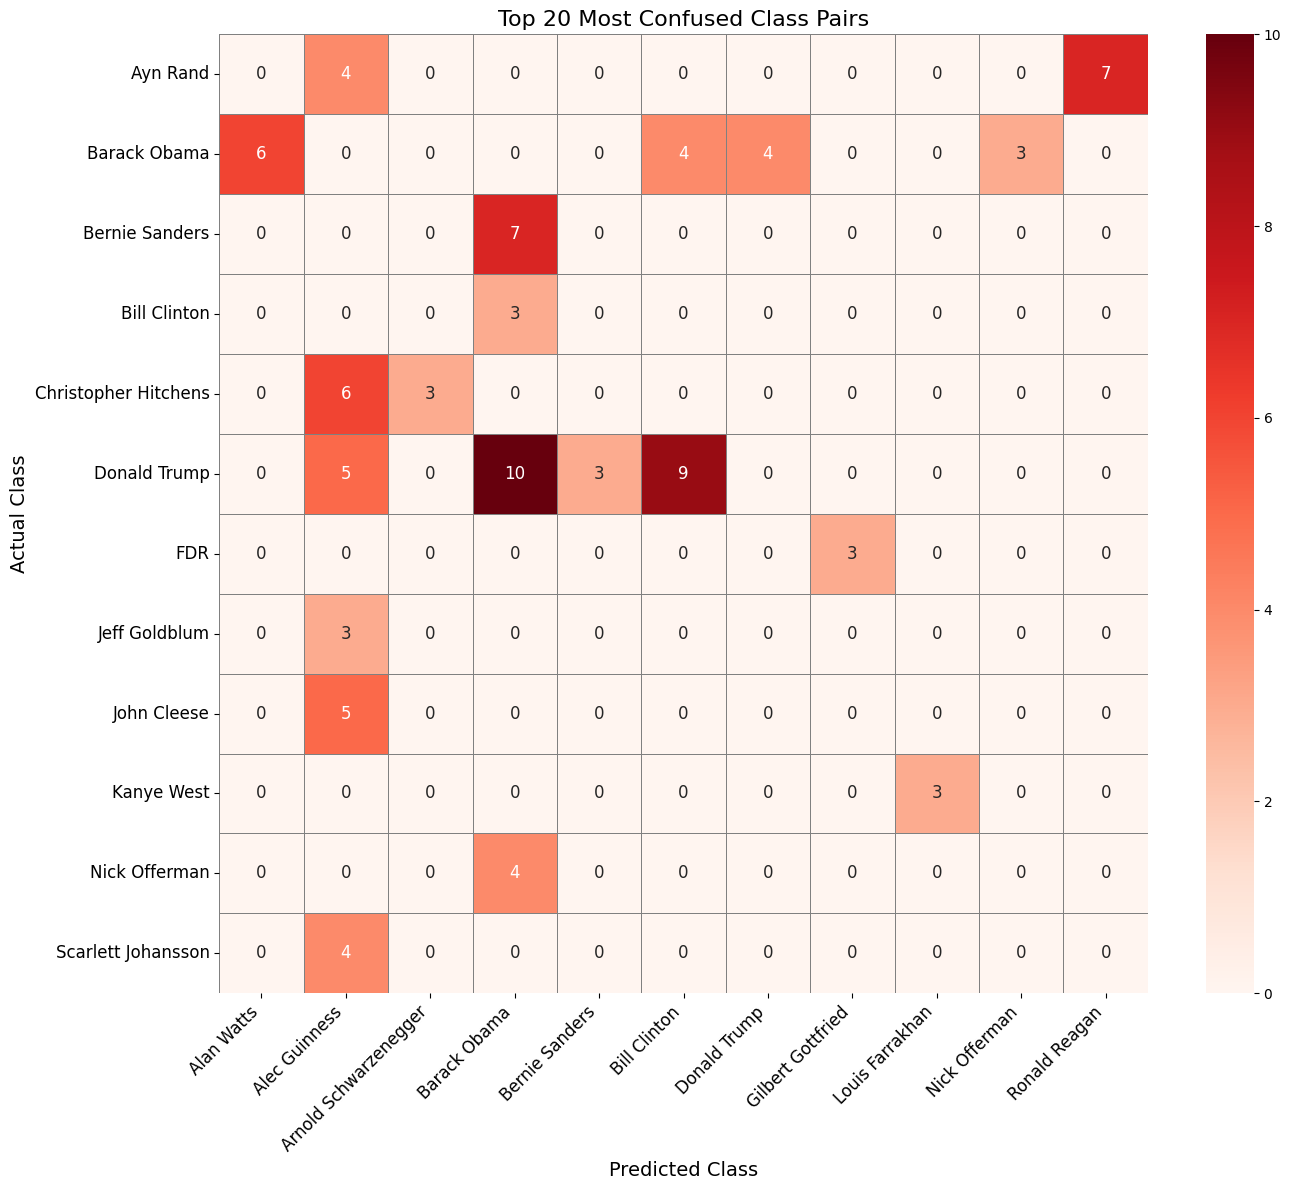

In [ ]:
top_confusions_matrix = top_confusions.pivot(index='Actual', columns='Predicted', values='Count').fillna(0)
top_confusions_matrix = top_confusions_matrix.astype(int)

# Create the annotated heatmap for top N confusions
plt.figure(figsize=(14, 12))
sns.heatmap(
    top_confusions_matrix,
    annot=True,
    fmt='d',
    cmap='Reds',
    linewidths=.5,
    linecolor='gray',
    cbar=True,
    annot_kws={"size": 12}
)

# Customize the plot
plt.title(f'Top {top_n} Most Confused Class Pairs', fontsize=16)
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

# Display the heatmap
plt.show()

## Save the model and download

In [ ]:
# Save the model in HDF5 format
saved_model_path = '/content/final_cnn_model.h5'  # Added .h5 extension
model.save(saved_model_path)
print(f"Model successfully saved to {saved_model_path}")

# Save the encoder
encoder_path = '/content/label_encoder.joblib'
joblib.dump(encoder, encoder_path)
print(f"LabelEncoder successfully saved to {encoder_path}")

# Download the HDF5 model file
files.download(saved_model_path)

# Download the LabelEncoder
files.download(encoder_path)

Model successfully saved to /content/final_cnn_model.h5
LabelEncoder successfully saved to /content/label_encoder.joblib


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>